In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from solvers.improvements_8x8 import solve_puzzle, SolverConfig

def reconstruct_from_board(puzzle_path, board, grid_size=8):
    """Reconstruct image from board dict."""
    img = cv2.imread(str(puzzle_path))
    h, w = img.shape[:2]
    ph, pw = h // grid_size, w // grid_size
    
    pieces = {}
    for idx in range(grid_size * grid_size):
        r, c = idx // grid_size, idx % grid_size
        pieces[idx] = img[r*ph:(r+1)*ph, c*pw:(c+1)*pw].copy()
    
    out = np.zeros((h, w, 3), dtype=np.uint8)
    for (row, col), pid in board.items():
        out[row*ph:(row+1)*ph, col*pw:(col+1)*pw] = pieces[pid]
    return cv2.cvtColor(out, cv2.COLOR_BGR2RGB)

def load_correct(image_id):
    path = Path(f'./Gravity Falls/correct/{image_id}.png')
    if not path.exists():
        return None
    img = cv2.imread(str(path))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def compute_piece_accuracy(solved_img, correct_img, grid_size=8):
    """
    Compute per-piece accuracy by comparing each piece position.
    Returns: (num_correct_pieces, total_pieces, accuracy_percentage)
    """
    if solved_img is None or correct_img is None:
        return 0, grid_size*grid_size, 0.0
    
    if solved_img.shape != correct_img.shape:
        correct_img = cv2.resize(correct_img, (solved_img.shape[1], solved_img.shape[0]))
    
    h, w = solved_img.shape[:2]
    ph, pw = h // grid_size, w // grid_size
    
    correct_pieces = 0
    total_pieces = grid_size * grid_size
    
    for r in range(grid_size):
        for c in range(grid_size):
            y1, y2 = r * ph, (r + 1) * ph
            x1, x2 = c * pw, (c + 1) * pw
            
            solved_piece = solved_img[y1:y2, x1:x2].astype(np.float32).flatten()
            correct_piece = correct_img[y1:y2, x1:x2].astype(np.float32).flatten()
            
            # NCC comparison
            s_norm = solved_piece - np.mean(solved_piece)
            c_norm = correct_piece - np.mean(correct_piece)
            ncc = np.dot(s_norm, c_norm) / (np.linalg.norm(s_norm) * np.linalg.norm(c_norm) + 1e-10)
            
            if ncc > 0.95:
                correct_pieces += 1
    
    accuracy = 100.0 * correct_pieces / total_pieces
    return correct_pieces, total_pieces, accuracy

In [2]:
# Load first 20 puzzle images
puzzle_dir = Path('./Gravity Falls/puzzle_8x8')
image_files = sorted(puzzle_dir.glob('*.jpg'), key=lambda x: int(x.stem))[:50]
print(f'Testing {len(image_files)} puzzle images')

Testing 50 puzzle images


In [3]:
# Solve all puzzles and compute per-piece accuracy
results = []
config = SolverConfig(verbose=False)  # Disable verbose output

for img_path in image_files:
    image_id = img_path.stem
    print(f'Solving {image_id}...', end=' ')
    
    # Solve
    result = solve_puzzle(str(img_path), config)
    board = result['board']
    arrangement = result['arrangement']
    score = result['score']
    
    # Reconstruct
    solved_img = reconstruct_from_board(img_path, board)
    correct_img = load_correct(image_id)
    
    # Compute accuracy
    correct_pieces, total_pieces, accuracy = compute_piece_accuracy(solved_img, correct_img)
    
    results.append({
        'id': image_id,
        'solved': solved_img,
        'correct': correct_img,
        'arrangement': arrangement,
        'score': score,
        'correct_pieces': correct_pieces,
        'total_pieces': total_pieces,
        'accuracy': accuracy
    })
    print(f'{correct_pieces}/{total_pieces} ({accuracy:.1f}%)')

# Summary
avg_accuracy = np.mean([r['accuracy'] for r in results])
print(f'\nAverage accuracy: {avg_accuracy:.1f}%')

Solving 0... ======================================================================
IMPROVED 8x8 PUZZLE SOLVER

[Phase 0] Loading and computing descriptors...
  Loaded 64 pieces (8x8)
  Computing edge descriptors...
  Border likelihood range: [24.21, 137260.02]
  Computing pairwise compatibility...

[Phase 1] Detecting confident pairs...
  Detected 0 locked pairs
  Created 64 superpieces
  Sizes: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]...

[Phase 2] Assembling puzzle...
  Hungarian row assembly...
    Phase 1: Building candidate rows...
    Got 5000 candidate rows
    Phase 2: Selecting best rows with Hungarian...
  Beam search (width=10000)...
    Row 1: 570000 -> 10000
    Row 2: 490000 -> 10000
    Row 3: 410000 -> 10000
    Row 4: 330000 -> 10000
    Row 5: 250000 -> 10000
    Row 6: 170000 -> 10000
    Row 7: 90000 -> 10000
    Row 8: 10000 -> 10000
  Hungarian score: 0.5900
  Assembly score: 0.5900

[Phase 3] Refining solution...

  Starting refinement pipeline...
  Local swap refinement 

KeyboardInterrupt: 

In [ ]:
# Display results table
print(f'{"ID":>4} | {"Correct":>8} | {"Total":>6} | {"Accuracy":>8} | {"Score":>8}')
print('-' * 50)
for r in results:
    print(f'{r["id"]:>4} | {r["correct_pieces"]:>8} | {r["total_pieces"]:>6} | {r["accuracy"]:>7.1f}% | {r["score"]:>8.4f}')
print('-' * 50)
print(f'{"AVG":>4} | {"":>8} | {"":>6} | {avg_accuracy:>7.1f}% |')

  ID |  Correct |  Total | Accuracy |    Score
--------------------------------------------------
   0 |       64 |     64 |   100.0% |   0.5301
   1 |       62 |     64 |    96.9% |   0.4799
   2 |       64 |     64 |   100.0% |   0.5596
   3 |       62 |     64 |    96.9% |   0.4960
   4 |        1 |     64 |     1.6% |   0.5716
   5 |       59 |     64 |    92.2% |   0.5221
   6 |        0 |     64 |     0.0% |   0.5246
   7 |       60 |     64 |    93.8% |   0.5234
   8 |        9 |     64 |    14.1% |   0.5368
   9 |       62 |     64 |    96.9% |   0.4658
  10 |       62 |     64 |    96.9% |   0.5267
  11 |       64 |     64 |   100.0% |   0.4919
  12 |       64 |     64 |   100.0% |   0.4906
  13 |       64 |     64 |   100.0% |   0.4975
  14 |        0 |     64 |     0.0% |   0.5493
  15 |        0 |     64 |     0.0% |   0.5622
  16 |        0 |     64 |     0.0% |   0.5395
  17 |       57 |     64 |    89.1% |   0.5416
  18 |        1 |     64 |     1.6% |   0.5271
  19 |   

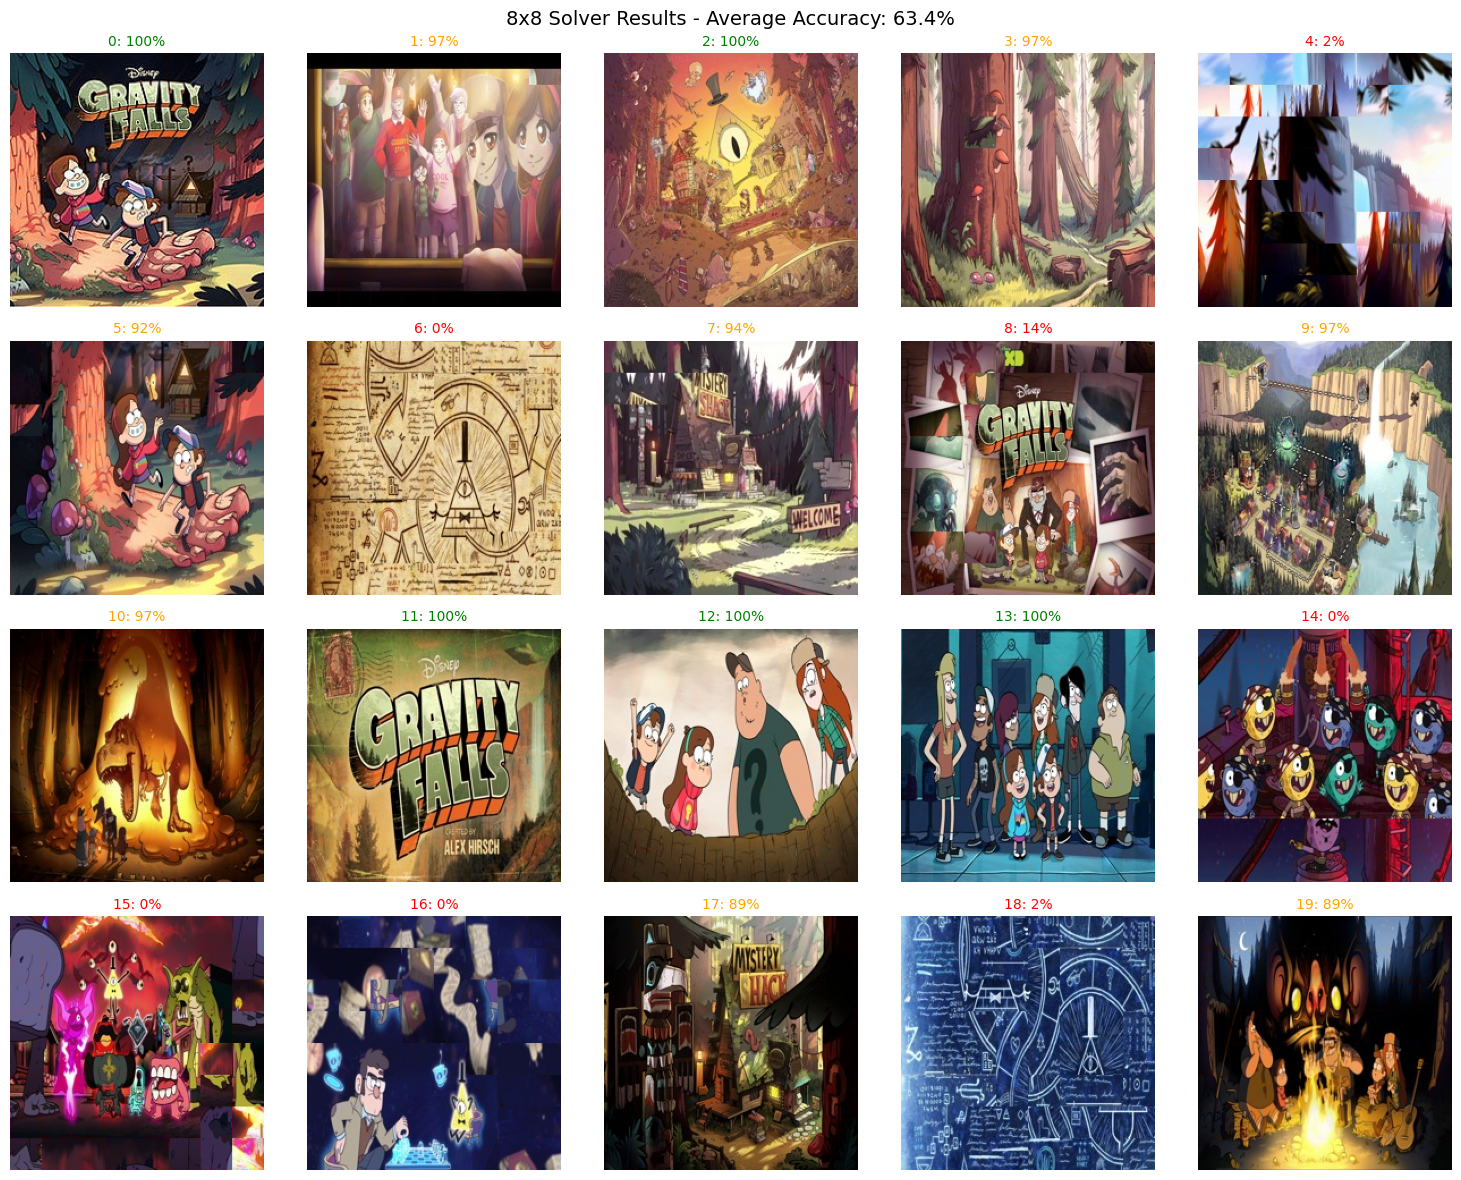

In [ ]:
# Show solved images with accuracy labels
cols = 5
rows = (len(results) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
axes = axes.flatten()

for i, res in enumerate(results):
    axes[i].imshow(res['solved'])
    color = 'green' if res['accuracy'] == 100 else 'orange' if res['accuracy'] >= 50 else 'red'
    axes[i].set_title(f"{res['id']}: {res['accuracy']:.0f}%", color=color, fontsize=10)
    axes[i].axis('off')

for j in range(len(results), len(axes)):
    axes[j].axis('off')

plt.suptitle(f'8x8 Solver Results - Average Accuracy: {avg_accuracy:.1f}%', fontsize=14)
plt.tight_layout()
plt.show()

Showing 5 worst results


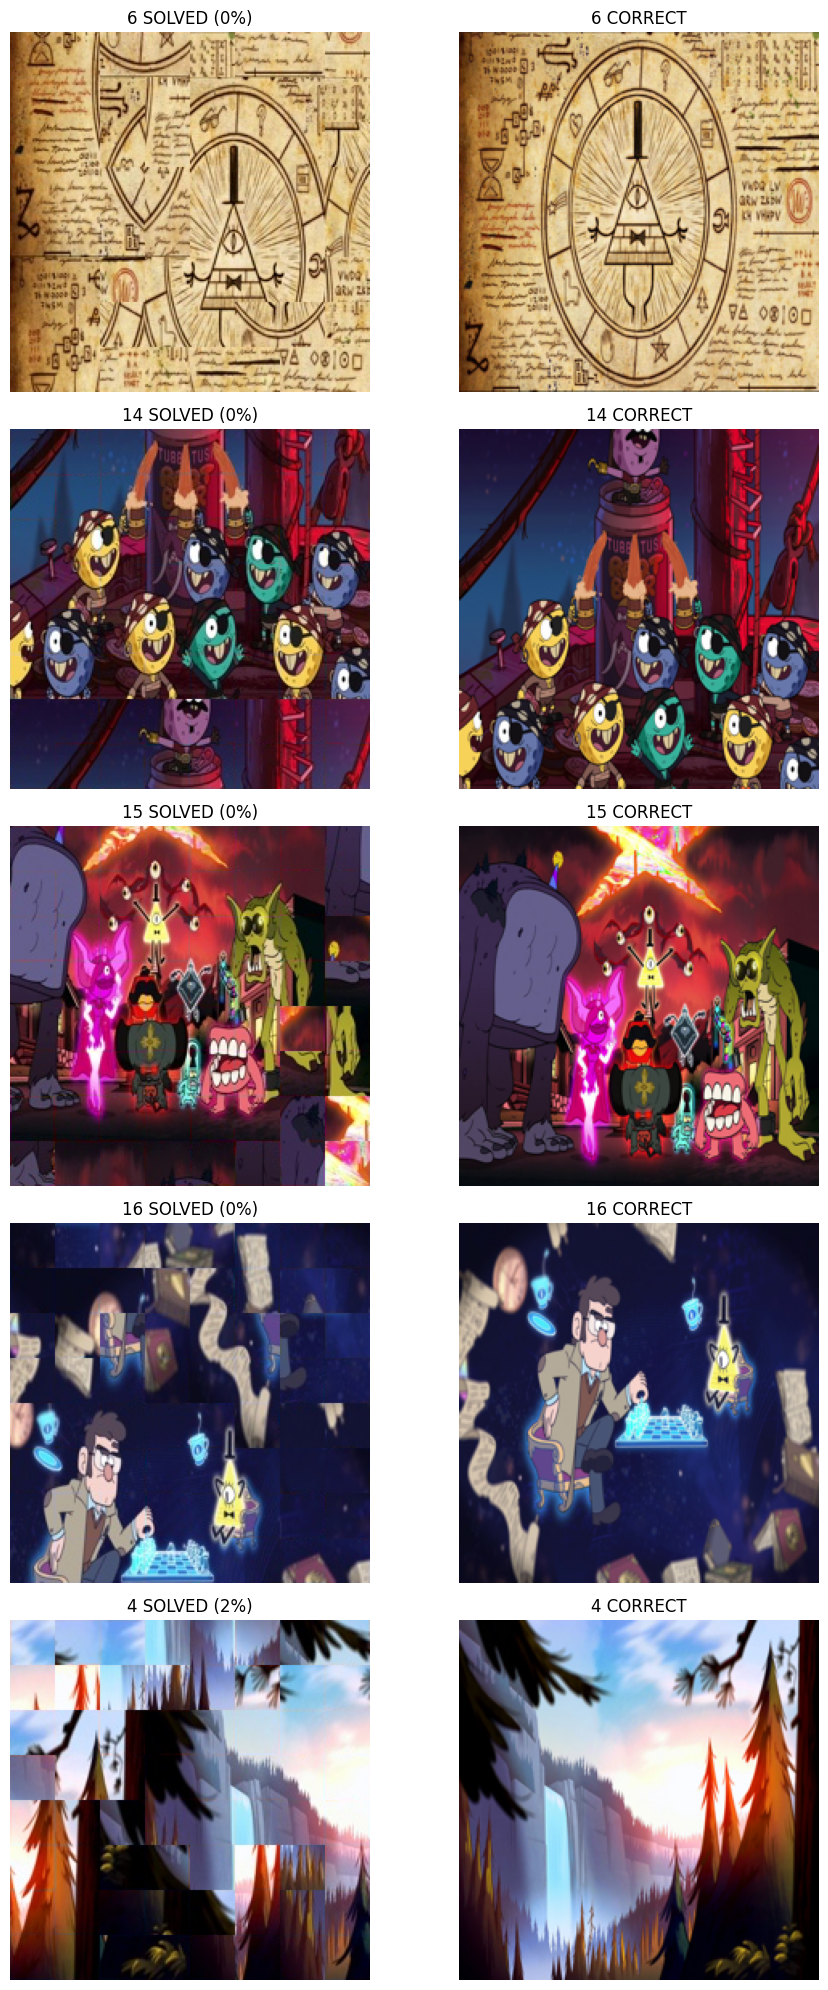

In [ ]:
# Show worst results side-by-side with ground truth
worst = sorted(results, key=lambda x: x['accuracy'])[:5]
print(f'Showing {len(worst)} worst results')

fig, axes = plt.subplots(len(worst), 2, figsize=(10, 4*len(worst)))
if len(worst) == 1:
    axes = axes.reshape(1, -1)

for i, res in enumerate(worst):
    axes[i, 0].imshow(res['solved'])
    axes[i, 0].set_title(f"{res['id']} SOLVED ({res['accuracy']:.0f}%)")
    axes[i, 0].axis('off')
    
    if res['correct'] is not None:
        axes[i, 1].imshow(res['correct'])
        axes[i, 1].set_title(f"{res['id']} CORRECT")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()